# Behavioural Cloning with Keras

## Dataset

Data samples are generated from the simulator. Samples include
1) 3 laps of center driving on the original track
2 laps of driving on the reverse track
3) one lap of recovery

Data is augmented by
1) Taking images from left and right cameras
2) Flipping the images

Data processing consists of
1) Cropping the image
2) Normalizing the image

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import sklearn
import keras.models
import h5py
from sklearn.model_selection import train_test_split
from keras.models import load_model


%matplotlib inline

Using TensorFlow backend.


In [3]:
#Flip the images
def flip_imgs(orig_imgs, orig_meas):
    new_imgs = [np.fliplr(image) for image in orig_imgs]
    new_meas = [-1*meas for meas in orig_meas]
    return new_imgs,new_meas

In [4]:
#Crop the images 
def crop_imgs(orig_imgs, crop_htop=70, crop_hbot=140): 
    new_imgs = [image[crop_htop:crop_hbot,:,:] for image in orig_imgs]        
    return new_imgs


***** Dataset before augmenting **********
 Total images   : 18537
 Training Set   : 14829 
 Validation Set : 3708                     
*******************************************

Steering angle adjustment for left and right images: 0.2deg(left), -0.2deg(right) 


Sample Frame - Each frame generates 6 cropped images 


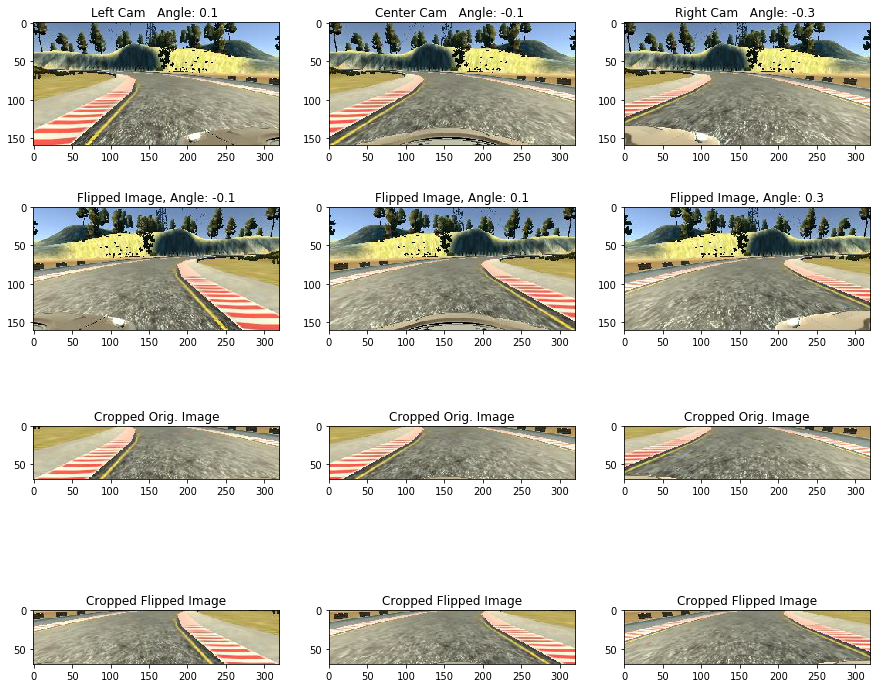

In [5]:
# Load data captured

data_dir_path = '../data/'
csv_file_name = 'driving_log.csv'
csv_file = data_dir_path + csv_file_name

sim_data_dir_path = '/Users/surya/Desktop/simulator/'

camera_adjust_angle = 0.2

# Images and their labels
car_images_path = []
car_steering_angles = []

#Note that for right turns, right camera angle < center camera angle < left camera angle (steering angle is +ve )
#For left turns, left_camera_angle < center camera angle < right camera angle (steering angle is -ve value)
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    
    for row in reader:
        steering_center = float(row[3])
        steering_left = steering_center + camera_adjust_angle
        steering_right = steering_center - camera_adjust_angle
        
        image_center_path = row[0].replace(sim_data_dir_path,data_dir_path) 
        image_left_path = row[1].replace(sim_data_dir_path,data_dir_path)
        image_right_path = row[2].replace(sim_data_dir_path,data_dir_path)
         
        orig_imgs_path = [image_left_path,image_center_path,image_right_path]
        orig_meas = [steering_left, steering_center, steering_right]
             
        car_images_path.extend(orig_imgs_path)
        car_steering_angles.extend(orig_meas)
        

#Display a random set (left, center, right) of car images captured
rand_samp = 3*np.random.randint(0,int(len(car_images_path)/3))
image_seq = ['Left Cam', 'Center Cam', 'Right Cam']

plt.figure(figsize=(15,13))
for i in range(3):
    image = plt.imread(car_images_path[rand_samp + i])
    cr_angle = car_steering_angles[rand_samp + i] 
    
    plt.subplot(4,3,i+1)
    plt.title("%s   Angle: %.1f "%(image_seq[i], cr_angle))
    plt.imshow(image)
    #print("image path is %s angle is %.1f"%(car_images_path[rand_samp+i],car_steering_angles[rand_samp+i]))
    
    newimg, newang = flip_imgs([image],[cr_angle])
    newimg = newimg[0]
    newang = newang[0]
    plt.subplot(4,3,i+4)
    plt.title("Flipped Image, Angle: %.1f"%(newang))
    plt.imshow(newimg)
    
    crp_orig = (crop_imgs([image]))[0] 
    plt.subplot(4,3,i+7)
    plt.title("Cropped Orig. Image")
    plt.imshow(crp_orig)
    
    crop_flp = (crop_imgs([newimg]))[0]
    plt.subplot(4,3,i+10)
    plt.title("Cropped Flipped Image")
    plt.imshow(crop_flp)
    
    #plt.tight_layout()

#print(image.shape, image[crop_htop:crop_hbot,:,:].shape)

car_images_path_train, car_images_path_valid, car_steering_angles_train, car_steering_angles_valid\
= train_test_split(car_images_path, car_steering_angles,test_size = 0.2)

total_samples = len(car_images_path)
train_samples = len(car_images_path_train)
valid_samples = len(car_images_path_valid)

print("\n***** Dataset before augmenting **********\n Total images   : %d\n Training Set   : %d \n Validation Set : %d \
                    "%(len(car_images_path),len(car_images_path_train),len(car_steering_angles_valid)))
print("*******************************************")

print("\nSteering angle adjustment for left and right images: %.1fdeg(left), %.1fdeg(right) \n"%(camera_adjust_angle, -1*camera_adjust_angle) )

print("\nSample Frame - Each frame generates 6 cropped images ")

In [6]:
#Generator for getting the images and post processing

def generator_images(car_images_path, car_steering_angles, batchsize=32):
    
    samples = len(car_images_path)
    batch_angles = []
    
    sklearn.utils.shuffle(car_images_path, car_steering_angles)
        
    while 1:
        for offset in range(0,samples,batchsize):
            batch_images_path = car_images_path[offset:offset+batchsize]
            batch_angles = car_steering_angles[offset:offset+batchsize]
            
            batch_images = []  
            
            for path in batch_images_path:
                image = plt.imread(path)
                batch_images.append(image)
            
            # Two options here - One is flip entire batch results in doubling the images
            # Other option is to take half the dataset and flip them keeping the batchsize the same
            
            new_imgs, new_meas = flip_imgs(batch_images, batch_angles)
            
            batch_images.extend(new_imgs)
            batch_angles.extend(new_meas)
            
            batch_images = np.array(crop_imgs(batch_images))
            batch_angles = np.array(batch_angles)
            
            sklearn.utils.shuffle(batch_images, batch_angles)
            #print("image path is %s angle is %f length is %d "%(batch_images_path[0],batch_angles[0], len(batch_images)))
            #plt.imshow(batch_images[0])
            
            yield batch_images,batch_angles

In [7]:
train_generator = generator_images(car_images_path_train,car_steering_angles_train,batchsize=32)
valid_generator = generator_images(car_images_path_valid,car_steering_angles_valid,batchsize=32)

In [8]:
#Keras model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Convolution2D, core, convolutional, MaxPooling2D, Lambda, Flatten

model = Sequential()

#Original image (160, 320, 3).. With cropping (70,320)
model.add(Lambda(lambda x : (x-127.5)/127.5, input_shape = (70,320,3)))

#adds 64 3x3 filters on input and a 2x2 max pooling 
#output after conv. is 16@70x318, after pooling 16@34x159 
model.add(Convolution2D(16,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#output after conv. is 32@77x157, after pooling 32@16x78          
model.add(Convolution2D(24,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
          
#output after conv. is 32@36x76, after pooling 64@7x38          
model.add(Convolution2D(32,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#output after conv. is 64@16x36, after pooling 128@2x18          
model.add(Convolution2D(64,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
          
#output is 64X8X18 = 9216          
model.add(Flatten())
model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))


In [9]:
from keras.optimizers import Adam

model.compile(loss = 'mse',optimizer = Adam(lr=0.0001))
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 70, 320, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 68, 318, 16)   448         lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 68, 318, 16)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 34, 159, 16)   0           activation_1[0][0]               
___________________________________________________________________________________________

In [10]:
model.fit_generator(train_generator,samples_per_epoch=train_samples,nb_epoch = 10,validation_data = valid_generator, nb_val_samples=1)
model.save('./model.h5')

#model.fit_generator(train_generator,samples_per_epoch=len(car_images_path_train),nb_epoch = 25,validation_data = valid_generator, nb_val_samples=len(car_images_path_valid))
#loss_and_metrics = model.evaluate()

Epoch 1/10
14848/14829 [==============================] - 34s - loss: 0.0433 - val_loss: 0.0246

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/10
14874/14829 [==============================] - 30s - loss: 0.0368 - val_loss: 0.0205